# Home Credit Project - Data analysis, LGB training and hyperparameter optimization


Credit is the life-blood of modern society. Without it, businesses cannot operate, individuals would find it impossible to build wealth through real estate or business ventures requiring financing, and domestic and international trade would come to a grinding halt.
As a particular form of widely consumed credit, home loans play a pivotal role in the American dream. Using a bank’s or lending institution’s leverage, individuals from many social strata can enter leveraged bets on properties with a value sometimes exceeding many years’ salary. If the bet pays off, the individual can keep the upside less financing cost, if the bet goes poorly, the lender naturally must absorb the loss. 
With an intrinsically long-time horizon (15-30 years), lending decisions have to blend current market and income potential with anticipated future developments, and these decisions are often based on historical credit and behavioral data.  
The home loan industry has used machine learning and artificial intelligence as well as traditional analytics and statistics for many years to determine the credit-worthiness of individuals and organizations. 

As the loan recipient population naturally shows wide-spread differences in credit history, age, income, etc., a fair (and profitable!) system should look to a more inclusive data set than just a credit report to determine which applicants represent the “best bet” for the issuance of a loan. 
In addition, and of personal interest to me is the question of bias embedded in the data. Specifically, what are some of the relevant “columns” in previous loan decisions (such as race, age, gender, ZIP code, etc.) that may reflect human biases in issuing loans and that may thus have contributed to a biased training set? See https://www.whitecase.com/publications/insight/algorithms-and-bias-what-lenders-need-know and https://www.americanbanker.com/news/can-ai-be-programmed-to-make-fair-lending-decisions for interesting discussions on underwriting bias as well as https://www.ibm.com/blogs/research/2017/12/ai-reducing-discrimination/ on attempts to reduce or eliminate bias.

Overall, the core challenge boils down to accurately predicting default risk (and thus, inversely, credit worthiness). Should the bank issue the loan? What are the key risk factors? Can large feature sets be reduced to a smaller set of core components to improve performance without sacrificing accuracy? 
This, at its core, is a (binary) classification problem and I will use available features in the training and test data sets as well as select features of the adjacent data files (see section below) to train the binary classifier. 

**Acknowledgements:**
I want to gratefully acknowledge the work of fellow Kaggle competitors and Kernel authors, specifically the outstanding overview and intro kernels by Will Koehresen here https://www.kaggle.com/willkoehrsen/start-here-a-gentle-introductionand here https://www.kaggle.com/willkoehrsen/intro-to-model-tuning-grid-and-random-search as well as the polynomial feature engineering laid out by Ann Antonova here https://www.kaggle.com/aantonova/797-lgbm-and-bayesian-optimization

**Methodology**
1. Data import
2. Data analysis
    * target variable distribution 
    * missing value analysis
    * variable type analysis
    * one-hot encoding for categoricals
    * outlier detection and management
    * age / employment history - first glance
    * family size
    * correlation analysis
    * age deep dive
3. Machine learning model design
    * Baseline
    * Kfold Cross validation
    * Domain expertise feature engineering
    * Polynomial feature engineering
    * Hyperparameter tuning
        * Random Search
        * GridSearch
        * Focused Random Search with additional visual hyperparameter exploration
        
**Room for future improvement - ('given unlimited time and compute resources')**
1. Bayesian hyperparameter optimization
2. Inclusion of additional features from other data files
3. PCA/feature reduction

# Imports

In [88]:
# numpy and pandas for data manipulation
import numpy as np
import pandas as pd 

# sklearn preprocessing for dealing with categorical variables
from sklearn.preprocessing import LabelEncoder

# File system manangement
import os

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

In [89]:
#Get working directory from file system
fileDir = os.path.dirname(os.path.realpath('__file__'))

#Get fully qualified path to subdirectory containing my training data
training_data_csv = os.path.join(fileDir, 'Data\\application_train.csv')

#Read training data into pandas dataframe from CSV using built-in method
app_train = pd.read_csv(training_data_csv)

#Visualize data
print('Training data shape: ', app_train.shape)
app_train.head()

Training data shape:  (307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [90]:
#Now do the same for test data
test_data_csv = os.path.join(fileDir, "Data\\application_test.csv")
app_test  = pd.read_csv(test_data_csv)
print("Test data shape: ", app_test.shape)
app_test.head()

Test data shape:  (48744, 121)


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


# Data Analysis
Performing deep dive source data analysis of the main files to figure out things like target distribution, correlation, etc.

Text(0.5,0,'Target variable 0 - 1')

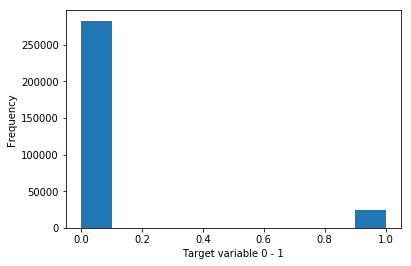

In [91]:
#Target variable distribution
app_train['TARGET'].value_counts()
app_train['TARGET'].astype(int).plot.hist();
plt.xlabel('Target variable 0 - 1')

Very, very uneven distribution!! This type of distribution lends itself actually quite well to a ROC AUC type analysis vs. a traditional accuracy score.

In [92]:
## Data consistency / missing values

# Function to calculate missing values by column# Funct 
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [93]:
# Missing values statistics
missing_values = missing_values_table(app_train)
missing_values.head(20)

Your selected dataframe has 122 columns.
There are 67 columns that have missing values.


,Missing Values,% of Total Values
COMMONAREA_MEDI,214865,69.9
COMMONAREA_AVG,214865,69.9
COMMONAREA_MODE,214865,69.9
NONLIVINGAPARTMENTS_MEDI,213514,69.4
NONLIVINGAPARTMENTS_MODE,213514,69.4
NONLIVINGAPARTMENTS_AVG,213514,69.4
FONDKAPREMONT_MODE,210295,68.4
LIVINGAPARTMENTS_MODE,210199,68.4
LIVINGAPARTMENTS_MEDI,210199,68.4
LIVINGAPARTMENTS_AVG,210199,68.4


Lots of missing values in 67 out of 122 columns!
Unsurprisingly, some of the more specific housing details are missing / may not be available or never have been collected for applicants depending on source geography, loan type, date of loan issued, and other bank-specific parameters. Since I will use LGBM that should be OK as this a very resilient model when it comes to missing values.

## Variable types
Categorical vs. non-categorical/continous/discrete data

In [94]:
# Number of each type of column
app_train.dtypes.value_counts()

float64    65
int64      41
object     16
dtype: int64

In [95]:
# Deeper dive on categoricals that will need to be one-hot encoded 
app_train.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

## One Hot Encoding to deal with categoricals

In [96]:
# one-hot encoding of categorical variables
app_train = pd.get_dummies(app_train)
app_test = pd.get_dummies(app_test)

print('Training Features shape: ', app_train.shape)
print('Testing Features shape: ', app_test.shape)

Training Features shape:  (307511, 246)
Testing Features shape:  (48744, 242)


Interesting result
* Training Features shape:  (307511, 246)
* Testing Features shape:  (48744, 242)

Clearly there were four more categorical items present in the training than in the testing data. 
Need to align these two dat sets to be able to safely process

In [97]:
#Set aside training labels from training dataframe for safekeeping
train_labels = app_train['TARGET']

# Discard things not found in both data frames
app_train, app_test = app_train.align(app_test, join = 'inner', axis = 1)

# Put target back
app_train['TARGET'] = train_labels

print('Training Features shape: ', app_train.shape)
print('Testing Features shape: ', app_test.shape)

Training Features shape:  (307511, 243)
Testing Features shape:  (48744, 242)


In [98]:
tmp_family_status = app_train.loc[:, app_train.columns.str.startswith('NAME_FAMILY_STATUS')]
tmp_family_status.head(20)

,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Widow
0,0,0,0,1,0
1,0,1,0,0,0
2,0,0,0,1,0
3,1,0,0,0,0
4,0,0,0,1,0
5,0,1,0,0,0
6,0,1,0,0,0
7,0,1,0,0,0
8,0,1,0,0,0
9,0,0,0,1,0


Excellent. Training features have all columns present in test features plus one extra column for "Target" variable.

## Outlier Detection and Management

Let's make sure our data set doesn't contain wildly skewed data, especially in important categories like age, family size, employment history, etc.

## Age exploration

In [99]:
#Check key columns for anomalies
(app_train['DAYS_BIRTH'] / -365).describe()

count    307511.000000
mean         43.936973
std          11.956133
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: DAYS_BIRTH, dtype: float64

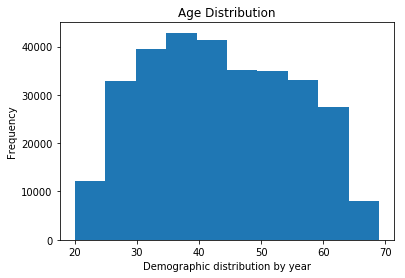

In [100]:
(app_train['DAYS_BIRTH'] / -365).astype(int).plot.hist(title = 'Age Distribution');
plt.xlabel('Demographic distribution by year');

Seems like a typical age distribution...validated using histogram as well. 

## Employment history exploration

Let's do the same for employment history

In [101]:
(app_train['DAYS_EMPLOYED']/365).describe()

count    307511.000000
mean        174.835742
std         387.056895
min         -49.073973
25%          -7.561644
50%          -3.323288
75%          -0.791781
max        1000.665753
Name: DAYS_EMPLOYED, dtype: float64

Hmmm...thousand year employment history seems excessive, unless this includes vampires and immortals.  Let's take a closer look. Are there only one category of outliers and what does it look like when we zoom in on just the probably values?

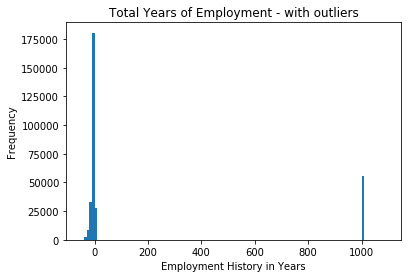

In [102]:
#Let's first take a look with the 1,000 year history included
bin_values = np.arange(start=-50, stop=1100, step=10)
(app_train['DAYS_EMPLOYED']/365).astype(int).plot.hist(title = 'Total Years of Employment - with outliers', bins=bin_values);
plt.xlabel('Employment History in Years');

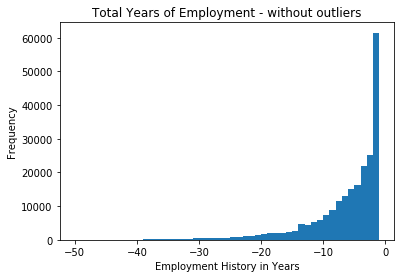

In [103]:
#Now let's zoom in on just the likely values
bin_values = np.arange(start=-50, stop=0, step=1)
(app_train['DAYS_EMPLOYED']/365).astype(int).plot.hist(title = 'Total Years of Employment - without outliers', bins=bin_values);
plt.xlabel('Employment History in Years');

Much more likely outcome between 0 and 40+ years of experience.

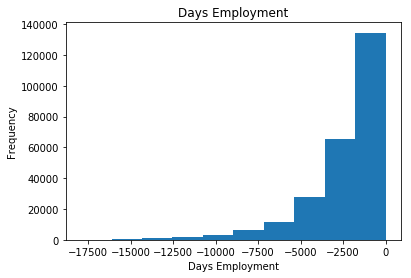

In [104]:
#Need to cauterize the outliers
# Add column where there are outliers and fill with "true" boolean values for outliers only
app_train['DAYS_EMPLOYED_OUTLIER'] = app_train["DAYS_EMPLOYED"] == 365243

# Replace the anomalous values with placeholder, numpy NaN value
app_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

app_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment');
plt.xlabel('Days Employment');


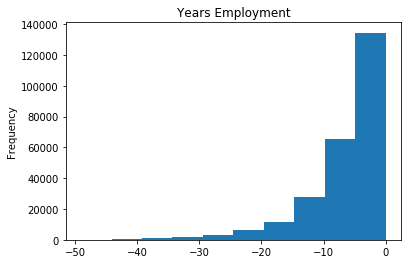

In [105]:
#Also show in years for consistency above and to double check that everything worked 
(app_train['DAYS_EMPLOYED']/365).plot.hist(title='Years Employment')

In [106]:
#Cauterize outliers in test data as well
app_test['DAYS_EMPLOYED_OUTLIER'] = app_test["DAYS_EMPLOYED"] == 365243
app_test["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace = True)

## Family size exploration

Let's see what family member (CNT_FAM_MEMBERS) and number of children (CNT_CHILDREN) tell us.

In [107]:
app_train['CNT_FAM_MEMBERS'].describe()

count    307509.000000
mean          2.152665
std           0.910682
min           1.000000
25%           2.000000
50%           2.000000
75%           3.000000
max          20.000000
Name: CNT_FAM_MEMBERS, dtype: float64

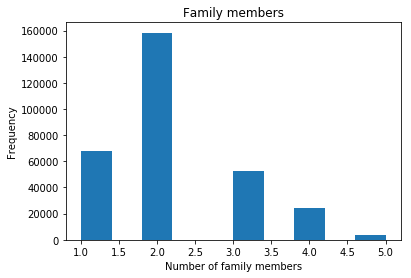

In [108]:
#Clipped data frame at 5 to remove outliers of 20 family members (very rare)
app_train['CNT_FAM_MEMBERS'].clip(0,5).astype(float).plot.hist(title = 'Family members');
plt.xlabel('Number of family members');

In [109]:
app_train['CNT_CHILDREN'].describe()

count    307511.000000
mean          0.417052
std           0.722121
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max          19.000000
Name: CNT_CHILDREN, dtype: float64

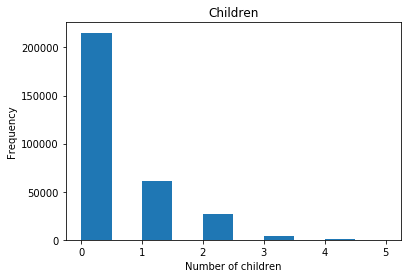

In [110]:
#Clipped data frame at 5 to remove outliers of 20 family members (very rare)
app_train['CNT_CHILDREN'].clip(0,5).astype(float).plot.hist(title = 'Children');
plt.xlabel('Number of children');

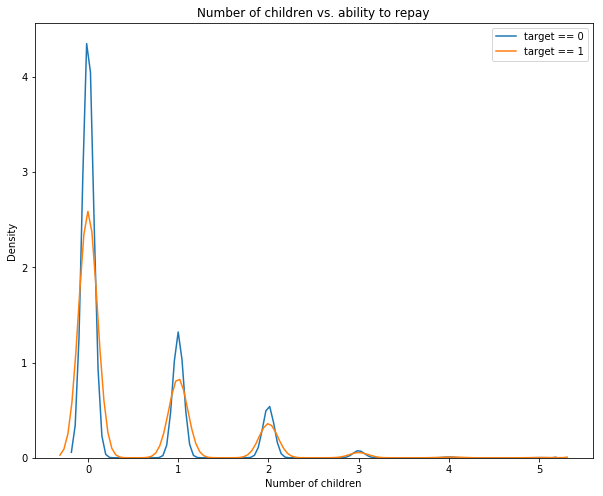

In [111]:
# Number of kids related to inability to pay?
plt.figure(figsize = (10, 8))

# KDE plot of loans that were repaid on time
sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, 'CNT_CHILDREN'].clip(0,5), label = 'target == 0')

# KDE plot of loans which were not repaid on time
sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, 'CNT_CHILDREN'].clip(0,5), label = 'target == 1')

# Labeling of plot
plt.xlabel('Number of children'); plt.ylabel('Density'); plt.title('Number of children vs. ability to repay');

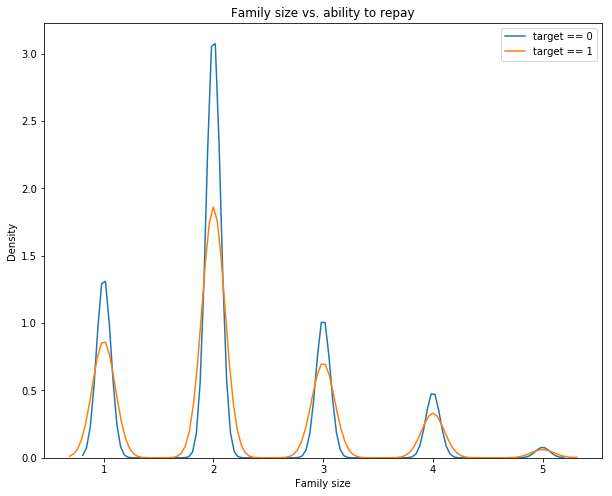

In [112]:
# Number of kids related to inability to pay?
plt.figure(figsize = (10, 8))

# KDE plot of loans that were repaid on time
sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, 'CNT_FAM_MEMBERS'].clip(0,5), label = 'target == 0')

# KDE plot of loans which were not repaid on time
sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, 'CNT_FAM_MEMBERS'].clip(0,5), label = 'target == 1')

# Labeling of plot
plt.xlabel('Family size'); plt.ylabel('Density'); plt.title('Family size vs. ability to repay');

In [113]:
# A slightly deeper dive yet. Determine single parent status through lambda function. 
# From our one hot encoding - NAME_FAMILY_STATUS_Separated | NAME_FAMILY_STATUS_Single / not married AND more than zero CNT_CHILDREN

family_frame = app_train[['TARGET','CNT_FAM_MEMBERS', 'CNT_CHILDREN', 'NAME_FAMILY_STATUS_Separated', 'NAME_FAMILY_STATUS_Single / not married']]
family_frame['SINGLE_PARENT'] = family_frame.apply(lambda r: 1 if ((r['NAME_FAMILY_STATUS_Separated'] == 1 or r['NAME_FAMILY_STATUS_Single / not married']==1) and r['CNT_CHILDREN'] >0)  else 0, axis=1)
# Percentage of single parents of all folks who couldn't repay
Non_Payer = family_frame[family_frame['TARGET'] == 1]
Single_Parent_Non_Payer = Non_Payer[Non_Payer['SINGLE_PARENT']==1]

print('Percentage of non-payers who are single parents is {:.2%}'.format(len(Single_Parent_Non_Payer.index) / len(Non_Payer.index)))
print('Percentage of non-payers {:.2%}'.format(len(Non_Payer.index) / len(app_train.index)))
print('Percentage in total population of single parents is {:.2%}'.format(family_frame['SINGLE_PARENT'].sum() / len(app_train.index)))


Percentage of non-payers who are single parents is 5.06%
Percentage of non-payers 8.07%
Percentage in total population of single parents is 3.99%


Single parents are slightly overrepresented in non-payer population. I'll take this into account when creating my engineered features later.

## Correlation Analysis
As a simple first cut at finding relevant features, let's look at overall correlations to Target variable

### Holistic View

In [114]:
#Looking at correlations to target variable
correlations = app_train.corr()['TARGET'].sort_values()

#Find and print top 10 positive correlations
print('Most Positive Correlations:\n', correlations.tail(10))
#Find and print top 10 negative correlations
print('\nMost Negative Correlations:\n', correlations.head(10))

Most Positive Correlations:
 REG_CITY_NOT_WORK_CITY         0.050994
DAYS_ID_PUBLISH                0.051457
CODE_GENDER_M                  0.054713
DAYS_LAST_PHONE_CHANGE         0.055218
NAME_INCOME_TYPE_Working       0.057481
REGION_RATING_CLIENT           0.058899
REGION_RATING_CLIENT_W_CITY    0.060893
DAYS_EMPLOYED                  0.074958
DAYS_BIRTH                     0.078239
TARGET                         1.000000
Name: TARGET, dtype: float64

Most Negative Correlations:
 EXT_SOURCE_3                           -0.178919
EXT_SOURCE_2                           -0.160472
EXT_SOURCE_1                           -0.155317
NAME_EDUCATION_TYPE_Higher education   -0.056593
CODE_GENDER_F                          -0.054704
NAME_INCOME_TYPE_Pensioner             -0.046209
DAYS_EMPLOYED_OUTLIER                  -0.045987
ORGANIZATION_TYPE_XNA                  -0.045987
FLOORSMAX_AVG                          -0.044003
FLOORSMAX_MEDI                         -0.043768
Name: TARGET, dtype: f

Interesting initial findings. EXT_SOURCE_n (1-3) is clearly negatively correlated with the "non-repayment" event, as is calendar age. 
This indicates that our external sources (like credit bureaus et al.) are doing a good job at predicting credit worthiness.
Also, somewhat intuitively, older people with more higher education (and women) are more likely to repay loans.

Positive correlations with inability to repay are "NAME_EDUCATION_TYPE_Secondary / secondary special" as the highest completed education level, "REG_CITY_NOT_WORK_CITY - Flag if client's permanent address does not match work address (1=different, 0=same, at city level)", "DAYS_ID_PUBLISH - How many days before the application did client change the identity document with which he applied for the loan" and "CODE_GENDER_M - Male applicant".
This intuitively makes sense...applicants whose work permanent address doesn't match their work address and who recently changed their identity document are apparently less stable (and ultimately less able or willing to repay their loan) than others.

Let's visualize both positive and negative correlations

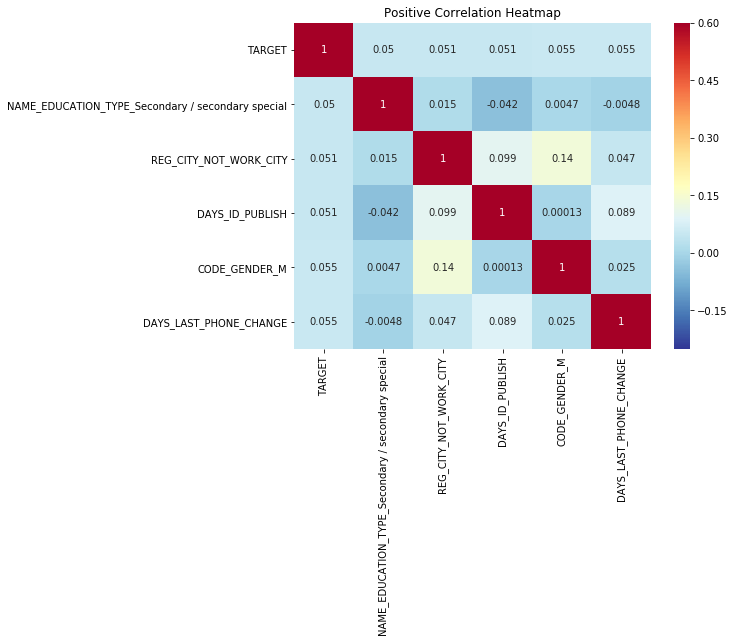

In [115]:
ext_data_pos = app_train[['TARGET', 'NAME_EDUCATION_TYPE_Secondary / secondary special', 'REG_CITY_NOT_WORK_CITY', 'DAYS_ID_PUBLISH', 'CODE_GENDER_M', 'DAYS_LAST_PHONE_CHANGE']]
ext_data_pos_corrs = ext_data_pos.corr()

plt.figure(figsize = (8, 6))

# Heatmap of correlations
sns.heatmap(ext_data_pos_corrs, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Positive Correlation Heatmap');

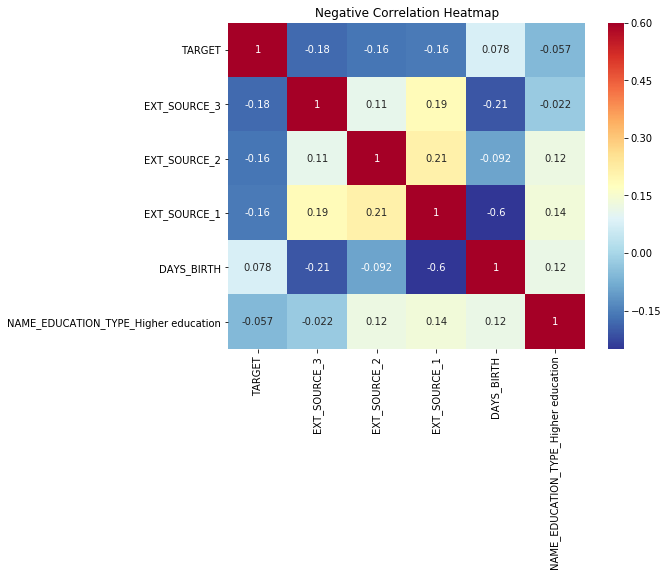

In [116]:
ext_data_neg = app_train[['TARGET', 'EXT_SOURCE_3', 'EXT_SOURCE_2', 'EXT_SOURCE_1', 'DAYS_BIRTH', 'NAME_EDUCATION_TYPE_Higher education']]
ext_data_neg_corrs = ext_data_neg.corr()

plt.figure(figsize = (8, 6))

# Heatmap of correlations
sns.heatmap(ext_data_neg_corrs, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Negative Correlation Heatmap');

### Age deep dive
Let's dive deeper into the age category, which seems to be a strong predictor in addition to external sources for our ability to repay.

In [117]:
# Flip days since birth into absolute values for easier processing later
app_train['DAYS_BIRTH'] = abs(app_train['DAYS_BIRTH'])

#Looking at failure to pay back by age group
age_data = app_train[['TARGET', 'DAYS_BIRTH']]
age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH'] / 365

# Bin the age data
age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins = np.linspace(20, 70, num = 11))


In [118]:
# Group all individuals into bins and calculate mean per bin
age_groups  = age_data.groupby('YEARS_BINNED').mean()
age_groups

,TARGET,DAYS_BIRTH,YEARS_BIRTH
YEARS_BINNED,,,
"(20.0, 25.0]",0.123036,8532.795625,23.377522
"(25.0, 30.0]",0.111436,10155.219250,27.822518
"(30.0, 35.0]",0.102814,11854.848377,32.479037
"(35.0, 40.0]",0.089414,13707.908253,37.555913
"(40.0, 45.0]",0.078491,15497.661233,42.459346
"(45.0, 50.0]",0.074171,17323.900441,47.462741
"(50.0, 55.0]",0.066968,19196.494791,52.593136
"(55.0, 60.0]",0.055314,20984.262742,57.491131
"(60.0, 65.0]",0.052737,22780.547460,62.412459


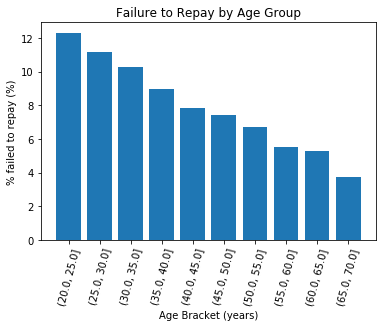

In [119]:
#Visualize the above
plt.bar(age_groups.index.astype(str), 100 * age_groups['TARGET'])

# Plot labeling
plt.xticks(rotation = 75); plt.xlabel('Age Bracket (years)'); plt.ylabel('% failed to repay (%)')
plt.title('Failure to Repay by Age Group');

No big shock there. Younger people have a harder time repaying loans than older people. 

# Machine Learning Model Design

Given the Kaggle competition's format of requiring submission of predictions on an unlableled data set (application_test.csv), I wanted to experiment locally first to select an approppriate model, experiment with additional feature engineering, etc. and then only submit select results that I was reasonably confident in to Kaggle.

## Baseline
I'll start with an out of the box Gradient Boosting Machine to establish a baseline on a subset of the data

In [120]:
# Import LightGBM 
import lightgbm as lgb

# Data splitting import
from sklearn.model_selection import train_test_split

N_FOLDS = 10
# Master switch to set number of evals.
# I experimented with 5, 20, and 100. Performance did not reliably increase with additional evals, as is the nature of random 
# experiments. While computationally VERY expensive, the 100 evals did not improve my score.
# Setting to tiny number for end-to-end run-throughs of the entire notebook.
MAX_EVALS = 40

In [121]:
# Sample 20000 rows (15000 for training, 5000 for testing)
subset = app_train.sample(n = 20000, random_state = 42)
print('Subset data shape: ', subset.shape)
subset.head()

Subset data shape:  (20000, 244)


,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,...,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,TARGET,DAYS_EMPLOYED_OUTLIER
245895,384575,2,207000.0,465457.5,52641.0,418500.0,0.009630,13297,-762.0,-637.0,...,0,0,0,0,0,0,0,0,0,False
98194,214010,0,247500.0,1281712.5,48946.5,1179000.0,0.006852,14778,-1141.0,-1610.0,...,0,1,0,0,0,0,1,0,0,False
36463,142232,0,202500.0,495000.0,39109.5,495000.0,0.035792,17907,-639.0,-2507.0,...,0,0,0,0,0,0,0,0,0,False
249923,389171,0,247500.0,254700.0,24939.0,225000.0,0.046220,19626,-6982.0,-11167.0,...,0,0,0,1,0,0,1,0,0,False
158389,283617,0,112500.0,308133.0,15862.5,234000.0,0.018850,20327,-1105.0,-7299.0,...,0,0,0,0,1,0,1,0,0,False


In [122]:
# Split into features and labels, split into train and test
# Extract the labels
labels = np.array(subset['TARGET'].astype(np.int32)).reshape((-1, ))
features = subset.drop(columns = ['TARGET', 'SK_ID_CURR'])

# Split into training and testing data
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 5000, random_state = 50)
print('Training features data shape: ', train_features.shape)
print('Testing features data shape:', test_features.shape)

Training features data shape:  (15000, 242)
Testing features data shape: (5000, 242)


Now onto actually experimenting with the LGBM default model, using KFold Cross Validation to get an initial stab at a ROC AUC score

In [123]:
# Use LGB functions to create a dataset
train_set = lgb.Dataset(data = train_features, label = train_labels)
test_set = lgb.Dataset(data = test_features, label = test_labels)

# Get default hyperparameters
model = lgb.LGBMClassifier()
default_params = model.get_params()

# Remove the number of estimators because we set this to 10000 in the cv call
del default_params['n_estimators']

# Cross validation with early stopping
cv_results = lgb.cv(default_params, train_set, num_boost_round = 10000, early_stopping_rounds = 100, 
                    metrics = 'auc', nfold = N_FOLDS, seed = 42)

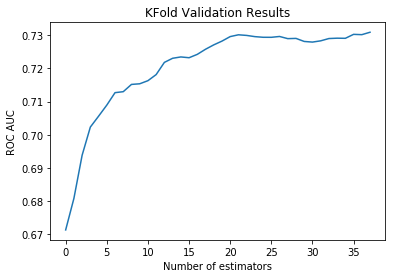

In [124]:
# Just a quick peek inside the cv_results dictionary
plt.plot(cv_results['auc-mean']); plt.xlabel('Number of estimators'); plt.ylabel('ROC AUC')
plt.title('KFold Validation Results');

In [125]:
#Print results
print('The maximum validation ROC AUC was: {:.5f} with a standard deviation of {:.5f}.'.format(cv_results['auc-mean'][-1], cv_results['auc-stdv'][-1]))
print('The optimal number of boosting rounds (estimators) was {}.'.format(len(cv_results['auc-mean'])))

The maximum validation ROC AUC was: 0.73091 with a standard deviation of 0.02271.
The optimal number of boosting rounds (estimators) was 38.


KFold CV ROC AUC score is 0.73091 with 10 folds. Now onto the test set to see how we do there.

In [126]:
from sklearn.metrics import roc_auc_score
# Optimal number of esimators found in cross validation above
model.n_estimators = len(cv_results['auc-mean'])

# Train and make predicions with model
model.fit(train_features, train_labels)
preds = model.predict_proba(test_features)[:, 1]
baseline_auc = roc_auc_score(test_labels, preds)

print('The baseline model scores {:.5f} ROC AUC on the test set.'.format(baseline_auc))

The baseline model scores 0.73781 ROC AUC on the test set.


Good portability from KFold to test set. 

Now let's run this on the full (blind) test set from the Kaggle competition to get our raw, initial submission for an "official score"

In [127]:
#Initial test
initial_test_ids = app_test['SK_ID_CURR']
initial_test = app_test.drop(columns = ['SK_ID_CURR'])

#Use existing model from above to create predictions for our test set
preds = model.predict_proba(initial_test)[:, 1]

# Generate submission file in approved format
submission = pd.DataFrame({'SK_ID_CURR': initial_test_ids, 'TARGET': preds})
submission.to_csv('submission_untuned_LGBM.csv', index = False)

And here is the official Kaggle result for the totally untuned out of the box LGBM - a score of 0.68025
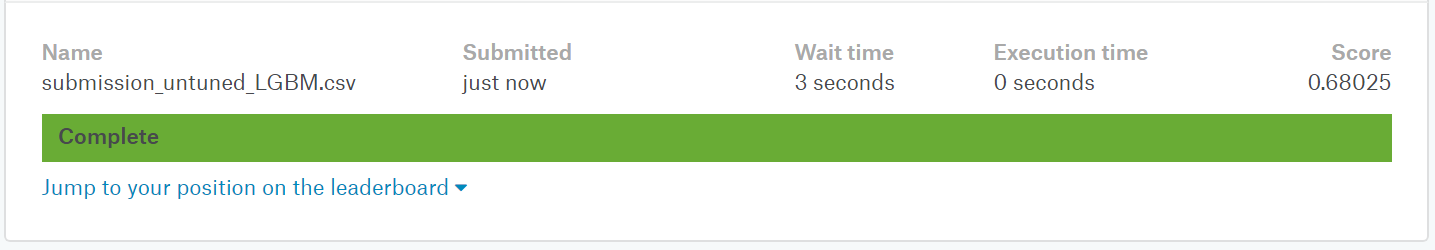

As we can see our actual full test set score is quite a bit lower than the sub-sampled test set and KFold validated model derived purely from the (labeled) training data.
Now on to tuning the hyperparameters to improve the performance of our model.

### Feature Engineering

To further improve the score, I'll try to add engineered features to the data set. 
These engineered features will be derived from the existing data using common sense hypotheses. Also using the single parent flag from data exploration chapter.

In [128]:
app_train_domain = app_train.copy()
app_test_domain = app_test.copy()

#### Domain expertise features

In [129]:
# Little helper function to add five feature columns onto my data frame
def feature_append(dataframe_in):
    dataframe_in['CREDIT_INCOME_PERCENT'] = dataframe_in['AMT_CREDIT'] / dataframe_in['AMT_INCOME_TOTAL']
    dataframe_in['CREDIT_TERM'] = dataframe_in['AMT_ANNUITY'] / dataframe_in['AMT_CREDIT']
    dataframe_in['DAYS_EMPLOYED_PERCENT'] = dataframe_in['DAYS_EMPLOYED'] / dataframe_in['DAYS_BIRTH']
    dataframe_in['INCOME_VS_FAMILY_SIZE'] = dataframe_in['AMT_INCOME_TOTAL'] / dataframe_in['CNT_FAM_MEMBERS']
    dataframe_in['INCOME_VS_CHILDREN'] = dataframe_in['AMT_INCOME_TOTAL'] / dataframe_in['CNT_CHILDREN']
    dataframe_in['SINGLE_PARENT'] = dataframe_in.apply(lambda r: 1 if ((r['NAME_FAMILY_STATUS_Separated'] == 1 or r['NAME_FAMILY_STATUS_Single / not married']==1) and r['CNT_CHILDREN'] >0)  else 0, axis=1)
    return dataframe_in


In [130]:
app_train_domain = feature_append(app_train_domain)
app_test_domain = feature_append(app_test_domain)
print(app_train_domain.shape)
print(app_test_domain.shape)

(307511, 250)
(48744, 249)


In [131]:
# Quick peek to see if anything has changed in correlation matrix as a naive way to evaluate impact of new features
correlations = app_train_domain.corr()['TARGET'].sort_values()

#Find and print top 10 positive correlations
print('Most Positive Correlations:\n', correlations.tail(10))
#Find and print top 10 negative correlations
print('\nMost Negative Correlations:\n', correlations.head(10))

Most Positive Correlations:
 REG_CITY_NOT_WORK_CITY         0.050994
DAYS_ID_PUBLISH                0.051457
CODE_GENDER_M                  0.054713
DAYS_LAST_PHONE_CHANGE         0.055218
NAME_INCOME_TYPE_Working       0.057481
REGION_RATING_CLIENT           0.058899
REGION_RATING_CLIENT_W_CITY    0.060893
DAYS_EMPLOYED_PERCENT          0.067955
DAYS_EMPLOYED                  0.074958
TARGET                         1.000000
Name: TARGET, dtype: float64

Most Negative Correlations:
 EXT_SOURCE_3                           -0.178919
EXT_SOURCE_2                           -0.160472
EXT_SOURCE_1                           -0.155317
DAYS_BIRTH                             -0.078239
NAME_EDUCATION_TYPE_Higher education   -0.056593
CODE_GENDER_F                          -0.054704
NAME_INCOME_TYPE_Pensioner             -0.046209
DAYS_EMPLOYED_OUTLIER                  -0.045987
ORGANIZATION_TYPE_XNA                  -0.045987
FLOORSMAX_AVG                          -0.044003
Name: TARGET, dtype: f

Not many made it into the top / bottom 10 by pure correlation. Oh well. Let's check more deeply using KFold and random parameter search.

In [132]:
# Redo extraction of train / test set for Kfold validation
# Sample 20000 rows (15000 for training, 5000 for testing)
subset = app_train_domain.sample(n = 20000, random_state = 42)
print('Subset data shape: ', subset.shape)
subset.head()

Subset data shape:  (20000, 250)


,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,...,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,TARGET,DAYS_EMPLOYED_OUTLIER,CREDIT_INCOME_PERCENT,CREDIT_TERM,DAYS_EMPLOYED_PERCENT,INCOME_VS_FAMILY_SIZE,INCOME_VS_CHILDREN,SINGLE_PARENT
245895,384575,2,207000.0,465457.5,52641.0,418500.0,0.009630,13297,-762.0,-637.0,...,0,0,0,False,2.248587,0.113095,-0.057306,51750.0,1.035000e+05,0
98194,214010,0,247500.0,1281712.5,48946.5,1179000.0,0.006852,14778,-1141.0,-1610.0,...,1,0,0,False,5.178636,0.038188,-0.077209,247500.0,inf,0
36463,142232,0,202500.0,495000.0,39109.5,495000.0,0.035792,17907,-639.0,-2507.0,...,0,0,0,False,2.444444,0.079009,-0.035684,101250.0,inf,0
249923,389171,0,247500.0,254700.0,24939.0,225000.0,0.046220,19626,-6982.0,-11167.0,...,1,0,0,False,1.029091,0.097915,-0.355753,247500.0,inf,0
158389,283617,0,112500.0,308133.0,15862.5,234000.0,0.018850,20327,-1105.0,-7299.0,...,1,0,0,False,2.738960,0.051479,-0.054361,112500.0,inf,0


In [133]:
# Split into features and labels, split into train and test
# Extract the labels
labels = np.array(subset['TARGET'].astype(np.int32)).reshape((-1, ))
features = subset.drop(columns = ['TARGET', 'SK_ID_CURR'])

# Split into training and testing data
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 5000, random_state = 50)
print('Training features data shape: ', train_features.shape)
print('Testing features data shape:', test_features.shape)

Training features data shape:  (15000, 248)
Testing features data shape: (5000, 248)


In [134]:
# Use LGB functions to create a dataset
train_set = lgb.Dataset(data = train_features, label = train_labels)
test_set = lgb.Dataset(data = test_features, label = test_labels)

# Get default hyperparameters
model = lgb.LGBMClassifier()
default_params = model.get_params()

# Remove the number of estimators because we set this to 10000 in the cv call
del default_params['n_estimators']

# Cross validation with early stopping
cv_results = lgb.cv(default_params, train_set, num_boost_round = 10000, early_stopping_rounds = 100, 
                    metrics = 'auc', nfold = N_FOLDS, seed = 42)

The maximum validation ROC AUC was: 0.73114 with a standard deviation of 0.02202.
The optimal number of boosting rounds (estimators) was 26.


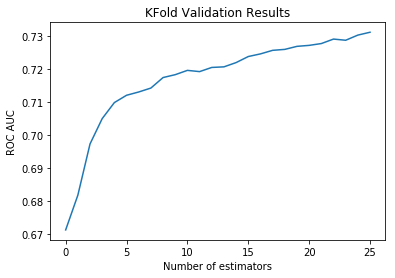

In [135]:
# Just a quick peek inside the cv_results dictionary
plt.plot(cv_results['auc-mean']); plt.xlabel('Number of estimators'); plt.ylabel('ROC AUC')
plt.title('KFold Validation Results');

#Print results
print('The maximum validation ROC AUC was: {:.5f} with a standard deviation of {:.5f}.'.format(cv_results['auc-mean'][-1], cv_results['auc-stdv'][-1]))
print('The optimal number of boosting rounds (estimators) was {}.'.format(len(cv_results['auc-mean'])))

#### Synthetic polynomial features

In [137]:
#Polynomial helper function
def poli_feature_append(dataframe_in):
    dataframe_in['app EXT_SOURCE mean'] = dataframe_in[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis = 1)
    dataframe_in['app EXT_SOURCE std'] = dataframe_in[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].std(axis = 1)
    dataframe_in['app EXT_SOURCE prod'] = dataframe_in['EXT_SOURCE_1'] * dataframe_in['EXT_SOURCE_2'] * dataframe_in['EXT_SOURCE_3']
    dataframe_in['app EXT_SOURCE_1 * EXT_SOURCE_2'] = dataframe_in['EXT_SOURCE_1'] * dataframe_in['EXT_SOURCE_2']
    dataframe_in['app EXT_SOURCE_1 * EXT_SOURCE_3'] = dataframe_in['EXT_SOURCE_1'] * dataframe_in['EXT_SOURCE_3']
    dataframe_in['app EXT_SOURCE_2 * EXT_SOURCE_3'] = dataframe_in['EXT_SOURCE_2'] * dataframe_in['EXT_SOURCE_3']
    dataframe_in['app EXT_SOURCE_1 * DAYS_EMPLOYED'] = dataframe_in['EXT_SOURCE_1'] * dataframe_in['DAYS_EMPLOYED']
    dataframe_in['app EXT_SOURCE_2 * DAYS_EMPLOYED'] = dataframe_in['EXT_SOURCE_2'] * dataframe_in['DAYS_EMPLOYED']
    dataframe_in['app EXT_SOURCE_3 * DAYS_EMPLOYED'] = dataframe_in['EXT_SOURCE_3'] * dataframe_in['DAYS_EMPLOYED']
    dataframe_in['app EXT_SOURCE_1 / DAYS_BIRTH'] = dataframe_in['EXT_SOURCE_1'] / dataframe_in['DAYS_BIRTH']
    dataframe_in['app EXT_SOURCE_2 / DAYS_BIRTH'] = dataframe_in['EXT_SOURCE_2'] / dataframe_in['DAYS_BIRTH']
    dataframe_in['app EXT_SOURCE_3 / DAYS_BIRTH'] = dataframe_in['EXT_SOURCE_3'] / dataframe_in['DAYS_BIRTH']
    dataframe_in['app AMT_CREDIT - AMT_GOODS_PRICE'] = dataframe_in['AMT_CREDIT'] - dataframe_in['AMT_GOODS_PRICE']
    dataframe_in['app AMT_CREDIT / AMT_GOODS_PRICE'] = dataframe_in['AMT_CREDIT'] / dataframe_in['AMT_GOODS_PRICE']
    dataframe_in['app AMT_CREDIT / AMT_ANNUITY'] = dataframe_in['AMT_CREDIT'] / dataframe_in['AMT_ANNUITY']
    dataframe_in['app AMT_CREDIT / AMT_INCOME_TOTAL'] = dataframe_in['AMT_CREDIT'] / dataframe_in['AMT_INCOME_TOTAL']
    dataframe_in['app AMT_INCOME_TOTAL / 12 - AMT_ANNUITY'] = dataframe_in['AMT_INCOME_TOTAL'] / 12. - dataframe_in['AMT_ANNUITY']
    dataframe_in['app AMT_INCOME_TOTAL / AMT_ANNUITY'] = dataframe_in['AMT_INCOME_TOTAL'] / dataframe_in['AMT_ANNUITY']
    dataframe_in['app AMT_INCOME_TOTAL - AMT_GOODS_PRICE'] = dataframe_in['AMT_INCOME_TOTAL'] - dataframe_in['AMT_GOODS_PRICE']
    dataframe_in['app OWN_CAR_AGE / DAYS_BIRTH'] = dataframe_in['OWN_CAR_AGE'] / dataframe_in['DAYS_BIRTH']
    dataframe_in['app OWN_CAR_AGE / DAYS_EMPLOYED'] = dataframe_in['OWN_CAR_AGE'] / dataframe_in['DAYS_EMPLOYED']
    dataframe_in['app DAYS_LAST_PHONE_CHANGE / DAYS_BIRTH'] = dataframe_in['DAYS_LAST_PHONE_CHANGE'] / dataframe_in['DAYS_BIRTH']
    dataframe_in['app DAYS_LAST_PHONE_CHANGE / DAYS_EMPLOYED'] = dataframe_in['DAYS_LAST_PHONE_CHANGE'] / dataframe_in['DAYS_EMPLOYED']
    dataframe_in['app DAYS_EMPLOYED - DAYS_BIRTH'] = dataframe_in['DAYS_EMPLOYED'] - dataframe_in['DAYS_BIRTH']
    return dataframe_in


In [147]:
app_train_domain_poli = poli_feature_append(app_train_domain)
app_test_domain_poli = poli_feature_append(app_test_domain)
print(app_train_domain_poli.shape)
print(app_test_domain_poli.shape)

(307511, 274)
(48744, 273)


In [148]:
# Check to see if anything has changed in correlation matrix as a naive way to evaluate impact of new features
correlations = app_train_domain_poli.corr()['TARGET'].sort_values()

#Find and print top 10 positive correlations
print('Most Positive Correlations:\n', correlations.tail(10))
#Find and print top 10 negative correlations
print('\nMost Negative Correlations:\n', correlations.head(10))

Most Positive Correlations:
 REGION_RATING_CLIENT                0.058899
REGION_RATING_CLIENT_W_CITY         0.060893
DAYS_EMPLOYED_PERCENT               0.067955
app AMT_CREDIT / AMT_GOODS_PRICE    0.069427
DAYS_EMPLOYED                       0.074958
app DAYS_EMPLOYED - DAYS_BIRTH      0.083361
app EXT_SOURCE_1 * DAYS_EMPLOYED    0.090050
app EXT_SOURCE_2 * DAYS_EMPLOYED    0.105509
app EXT_SOURCE_3 * DAYS_EMPLOYED    0.110831
TARGET                              1.000000
Name: TARGET, dtype: float64

Most Negative Correlations:
 app EXT_SOURCE mean               -0.222052
app EXT_SOURCE_2 * EXT_SOURCE_3   -0.199487
app EXT_SOURCE prod               -0.188552
app EXT_SOURCE_1 * EXT_SOURCE_3   -0.187832
EXT_SOURCE_3                      -0.178919
app EXT_SOURCE_1 * EXT_SOURCE_2   -0.175575
EXT_SOURCE_2                      -0.160472
EXT_SOURCE_1                      -0.155317
app EXT_SOURCE_1 / DAYS_BIRTH     -0.142094
app EXT_SOURCE_3 / DAYS_BIRTH     -0.115915
Name: TARGET, dtype: f

Bingo! Lots of new strongly correlated variables!!

In [149]:
# Redo extraction of train / test set for Kfold validation
# Sample 20000 rows (15000 for training, 5000 for testing)
subset = app_train_domain_poli.sample(n = 20000, random_state = 42)
print('Subset data shape: ', subset.shape)


Subset data shape:  (20000, 274)


In [150]:
# Split into features and labels, split into train and test
# Extract the labels
labels = np.array(subset['TARGET'].astype(np.int32)).reshape((-1, ))
features = subset.drop(columns = ['TARGET', 'SK_ID_CURR'])

# Split into training and testing data
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 5000, random_state = 50)
print('Training features data shape: ', train_features.shape)
print('Testing features data shape:', test_features.shape)

Training features data shape:  (15000, 272)
Testing features data shape: (5000, 272)


In [151]:
# Use LGB functions to create a dataset
train_set = lgb.Dataset(data = train_features, label = train_labels)
test_set = lgb.Dataset(data = test_features, label = test_labels)

# Get default hyperparameters
model = lgb.LGBMClassifier()
default_params = model.get_params()

# Remove the number of estimators because we set this to 10000 in the cv call
del default_params['n_estimators']

# Cross validation with early stopping
cv_results = lgb.cv(default_params, train_set, num_boost_round = 10000, early_stopping_rounds = 100, 
                    metrics = 'auc', nfold = N_FOLDS, seed = 42)

The maximum validation ROC AUC was: 0.73063 with a standard deviation of 0.02060.
The optimal number of boosting rounds (estimators) was 17.


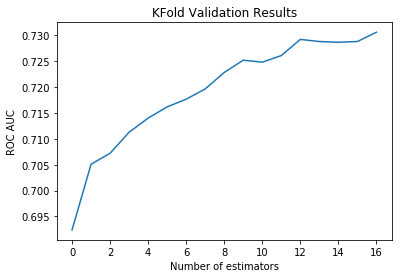

In [152]:
# Just a quick peek inside the cv_results dictionary
plt.plot(cv_results['auc-mean']); plt.xlabel('Number of estimators'); plt.ylabel('ROC AUC')
plt.title('KFold Validation Results');

#Print results
print('The maximum validation ROC AUC was: {:.5f} with a standard deviation of {:.5f}.'.format(cv_results['auc-mean'][-1], cv_results['auc-stdv'][-1]))
print('The optimal number of boosting rounds (estimators) was {}.'.format(len(cv_results['auc-mean'])))

Pretty much flat on the ROC AUC, but huge reduction in boosting rounds due to bigger feature space, some with strong correlation.

## Hyperparameter Tuning 
As a first cut, I am using RandomSearch to narrow down the overall field of candidate hyperparameters.
We'll need and Objective Function, the Hyperparameter Domain, an algorithm to pick hyperparameters randomly and a data struct to store and ultimately serialize results.

### Random Search

#### Objective Function
Generalized utility objective function to process hyperparameter domain

In [153]:
def objective(hyperparameters, iteration):
   # Outputs the CV score per hyperparameter set
    
    # Number of estimators will be found using early stopping
    if 'n_estimators' in hyperparameters.keys():
        del hyperparameters['n_estimators']
    
     # Perform n_folds cross validation
    cv_results = lgb.cv(hyperparameters, train_set, num_boost_round = 10000, nfold = N_FOLDS, 
                        early_stopping_rounds = 100, metrics = 'auc', seed = 42)
    
    # results to retun
    score = cv_results['auc-mean'][-1]
    estimators = len(cv_results['auc-mean'])
    hyperparameters['n_estimators'] = estimators 
    
    return [score, hyperparameters, iteration]

#### Data structure to hold results
A simple data frame correctly sized to Max_evals parameter

In [154]:
random_results = pd.DataFrame(columns = ['score', 'params', 'iteration', 'start_time', 'stop_time', 'elapsed_time'],
                              index = list(range(MAX_EVALS)))

#### Domain
Obtain dictionary output of hyperparameters for generic LGBM model

In [155]:
model = lgb.LGBMModel()
model.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': True,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

Of the 19 hyperparameters, only a subset are of interest. Specifically, we'll restrict our domain to the following 10 hyperparameters.
For better segmentation of learning rate, we are using log space list.
Binning, min_child_samples etc. will happen in linear space in linear increments.

In [156]:
# Hyperparameter domain
param_grid = {
    'boosting_type': ['gbdt', 'goss', 'dart'],
    'num_leaves': list(range(20, 100)),
    'learning_rate': list(np.logspace(np.log10(0.005), np.log10(0.5), base = 10, num = 1000)), #more elegant way of covering learning rate continuum than hardcoding values
    'subsample_for_bin': list(range(20000, 300000, 20000)),
    'min_child_samples': list(range(20, 500, 5)),
    'reg_alpha': list(np.linspace(0, 1)),
    'reg_lambda': list(np.linspace(0, 1)),
    'colsample_bytree': list(np.linspace(0.6, 1, 10)),
    'subsample': list(np.linspace(0.5, 1, 100)),
    'is_unbalance': [True, False]
}

#### Algorithm to iterate through randomly selected hyperparameters until MAX_EVAL is reached
First, need to be able to populate a random sub-sample from the overall hyperparameter grab bag above.

In [157]:
import random
import datetime
import csv
random.seed(50)

In [158]:
def random_search(param_grid, max_evals = MAX_EVALS):
        
    # Dataframe for results
    results = pd.DataFrame(columns = ['score', 'params', 'iteration', 'start_time', 'stop_time', 'elapsed_time'],
                                  index = list(range(MAX_EVALS)))
    
    # Keep searching until reach max evaluations
    for i in range(MAX_EVALS):
        #Measure time it takes for each iteration and record
        start_time = datetime.datetime.now()
        # Choose random hyperparameters
        hyperparameters = {k: random.sample(v, 1)[0] for k, v in param_grid.items()}
        hyperparameters['subsample'] = 1.0 if hyperparameters['boosting_type'] == 'goss' else hyperparameters['subsample']

        # Evaluate randomly selected hyperparameters, keep track of execution time
        eval_results = objective(hyperparameters, i)
        stop_time = datetime.datetime.now()
        elapsed_time = stop_time -start_time
        eval_results.extend([start_time,stop_time, elapsed_time])
        results.loc[i, :] = eval_results
        
        # Generate output file after each iteration
        of_connection = open(out_file, 'a')
        writer = csv.writer(of_connection)
        writer.writerow(eval_results)
        
        # make sure to close connection
        of_connection.close()
        
    # Sort with best score on top
    results.sort_values('score', ascending = False, inplace = True)
    results.reset_index(inplace = True)
    return results 

In [159]:
# Create file and open connection
out_file = 'random_search_results_' + str(MAX_EVALS) +'_iterations.csv'
of_connection = open(out_file, 'w')
writer = csv.writer(of_connection)

# Write column names
headers = ['score', 'hyperparameters', 'iteration','start_time', 'stop_time', 'elapsed_time']
writer.writerow(headers)
of_connection.close()

Ready to go! (Computationally VERY EXPENSIVE!)

In [160]:
# lives in its own cell as it is computationally expensive
random_results = random_search(param_grid)

In [184]:
import pprint

print('The best validation score was {:.5f}'.format(random_results.loc[0, 'score']))
print('\nThe best hyperparameters were:')

pprint.pprint(random_results.loc[0, 'params'])

The best validation score was 0.74690

The best hyperparameters were:
{'boosting_type': 'gbdt',
 'colsample_bytree': 0.6,
 'is_unbalance': False,
 'learning_rate': 0.015902760076664597,
 'metric': 'auc',
 'min_child_samples': 175,
 'n_estimators': 73,
 'num_leaves': 62,
 'reg_alpha': 0.673469387755102,
 'reg_lambda': 0.44897959183673464,
 'subsample': 1.0,
 'subsample_for_bin': 60000,
 'verbose': 1}


Now let's test this again against our "test" set

In [162]:
# Get the best parameters
random_search_params = random_results.loc[0, 'params']

# Create, train, test model
model = lgb.LGBMClassifier(**random_search_params, random_state = 42)
model.fit(train_features, train_labels)
preds = model.predict_proba(test_features)[:, 1]

print('The best model from random search scores {:.5f} ROC AUC on the test set.'.format(roc_auc_score(test_labels, preds)))

The best model from random search scores 0.74321 ROC AUC on the test set.


A slight improvement over the totally out of the box LGBM (which yielded 0.73781 ROC AUC). 

Now let's run it against the full test set for the Kaggle competition again to get an official score.

In [164]:
#Random parameter test
random_param_search_test_ids = app_test_domain_poli['SK_ID_CURR']
random_param_search_test = app_test_domain_poli.drop(columns = ['SK_ID_CURR'])
print(random_param_search_test.shape)

#Use existing model from above to create predictions for our test set
preds = model.predict_proba(random_param_search_test)[:, 1]

# Generate submission file in approved format
submission = pd.DataFrame({'SK_ID_CURR': random_param_search_test_ids, 'TARGET': preds})
submission.to_csv('submission_random_param_search_LGBM.csv', index = False)

(48744, 272)


Improvement in the officially scored Kaggle category. The new result is 0.71985 vs. the earlier 0.68025.

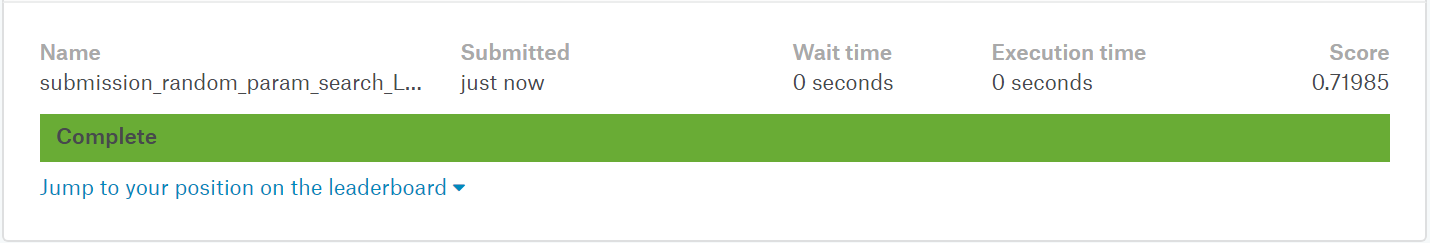

### Refining Random Search with GridSearch

The best ROC AUC score in all experiments with RandomSearch was the below parameter grid

In [227]:
best_param_grid = {
    'boosting_type': 'gbdt', 
    'num_leaves': 62, 
    'learning_rate': 0.015902760076664597, 
    'subsample_for_bin': 60000, 
    'min_child_samples': 175, 
    'reg_alpha': 0.673469387755102, 
    'reg_lambda': 0.44897959183673464, 
    'colsample_bytree': 0.6, 
    'subsample': 1.0, 
    'is_unbalance': False, 
    'metric': 'auc', 
    'verbose': 1, 
    'n_estimators': 73
}  
    

I exported the overall results from "random_search_results_40_iterations.csv" and flattened the parameter grids into individual columns. After sorting by ROC AUC, I then took the range of optimal values indicated by the random search results to indicate the "centroid" for a GridSearch. The processed file "GridSearch Hyperparameters - Expanded Feature Space.xlsx" is attached to this submission.

In [228]:
GridSearch_param_grid = {
    'boosting_type': ['gbdt', 'dart'],
    'num_leaves': list(range(15, 100,5)), 
    'learning_rate': list(np.logspace(np.log10(0.003), np.log10(0.05), base = 10, num = 10)),#except one outlier, all learning rates below 0.08, so restricting this domain severly
    'subsample_for_bin': list(range(20000, 110000, 10000)),
    'min_child_samples': list(range(120, 500, 10)), 
    'reg_alpha': list(np.linspace(0.1, 0.8,5)),
    'reg_lambda': list(np.linspace(0.1, 0.8,5)),
    'colsample_bytree': list(np.linspace(0.6, 0.9, 5)),
    'subsample': list(np.linspace(0.6, 0.9, 5)),
    'is_unbalance': [True, False]
}

In [233]:
# Create parameter grid to hold results
grid_results = pd.DataFrame(columns = ['score', 'params', 'iteration', 'start_time', 'stop_time', 'elapsed_time'],
                              index = list(range(MAX_EVALS)))

In [234]:
# Set max iterations for GridSearch

MAX_GRIDSEARCH_EVALS = 40

import itertools

def grid_search(param_grid, max_evals = MAX_GRIDSEARCH_EVALS):
       
    # Dataframe to store results
    results = pd.DataFrame(columns = ['score', 'params', 'iteration', 'start_time', 'stop_time', 'elapsed_time'],
                              index = list(range(MAX_GRIDSEARCH_EVALS)))
    
    # https://codereview.stackexchange.com/questions/171173/list-all-possible-permutations-from-a-python-dictionary-of-lists
    keys, values = zip(*GridSearch_param_grid.items())
    
    i = 0
    
    # Iterate through every possible combination of hyperparameters
    for v in itertools.product(*values):
        
        # Time stamp - start
        start_time = datetime.datetime.now()
        # Create a hyperparameter dictionary
        hyperparameters = dict(zip(keys, v))
        
                
        # Evaluate the hyperparameters
        eval_results = objective(hyperparameters, i)
        stop_time = datetime.datetime.now()
        elapsed_time = stop_time -start_time
        eval_results.extend([start_time,stop_time, elapsed_time])
        results.loc[i, :] = eval_results
        
        i += 1
        # Append output file after each iteration
        of_connection = open(out_file, 'a')
        writer = csv.writer(of_connection)
        writer.writerow(eval_results)
        
        # Close connection
        of_connection.close()        
        # Have to limit in recognition of limited compute power and time available
        if i > MAX_GRIDSEARCH_EVALS:
            break
       
    # Sort with best score on top
    results.sort_values('score', ascending = False, inplace = True)
    results.reset_index(inplace = True)
    
    return results    

In [235]:
# Create file and open connection
out_file = 'grid_search_results_domain_features_' + str(MAX_GRIDSEARCH_EVALS) +'_iterations.csv'
of_connection = open(out_file, 'w')
writer = csv.writer(of_connection)

# Write column names
headers = ['score', 'hyperparameters', 'iteration','start_time', 'stop_time', 'elapsed_time']
writer.writerow(headers)
of_connection.close()

In [236]:
# Computationally expense, lives in its own cell for safety!
grid_results = grid_search(GridSearch_param_grid)

In [237]:
# Results, please!
print('The best validation score was {:.5f}'.format(grid_results.loc[0, 'score']))
print('\nThe best hyperparameters were:')

import pprint
pprint.pprint(grid_results.loc[0, 'params'])

The best validation score was 0.74814

The best hyperparameters were:
{'boosting_type': 'gbdt',
 'colsample_bytree': 0.6,
 'is_unbalance': True,
 'learning_rate': 0.003000000000000001,
 'metric': 'auc',
 'min_child_samples': 120,
 'n_estimators': 1743,
 'num_leaves': 15,
 'reg_alpha': 0.1,
 'reg_lambda': 0.1,
 'subsample': 0.6,
 'subsample_for_bin': 20000,
 'verbose': 1}


In [238]:
# Get the best parameters
grid_search_params = grid_results.loc[0, 'params']

# Create, train, test model
model = lgb.LGBMClassifier(**grid_search_params, random_state=42)
model.fit(train_features, train_labels)

preds = model.predict_proba(test_features)[:, 1]

print('The best model from grid search scores {:.5f} ROC AUC on the test set.'.format(roc_auc_score(test_labels, preds)))

The best model from grid search scores 0.73985 ROC AUC on the test set.


In [239]:
#GridSearch parameter test
gridsearch_param_search_test_ids = app_test_domain['SK_ID_CURR']
gridsearch_param_search_test = app_test_domain.drop(columns = ['SK_ID_CURR'])

#Use existing model from above to create predictions for our test set
preds = model.predict_proba(gridsearch_param_search_test)[:, 1]

# Generate submission file in approved format
submission = pd.DataFrame({'SK_ID_CURR': gridsearch_param_search_test_ids, 'TARGET': preds})
submission.to_csv('submission_gridsearch_param_search_plus_domain_features_LGBM.csv', index = False)

GridSearch performed as expected, but given the limited compute and time budgets, I was only able to explore 40 permutations. A few of the results shown below. With more compute and time, I could have run a more exhaustive GridSearch, but at 4 minutes per set this could get very expensive very quickly!!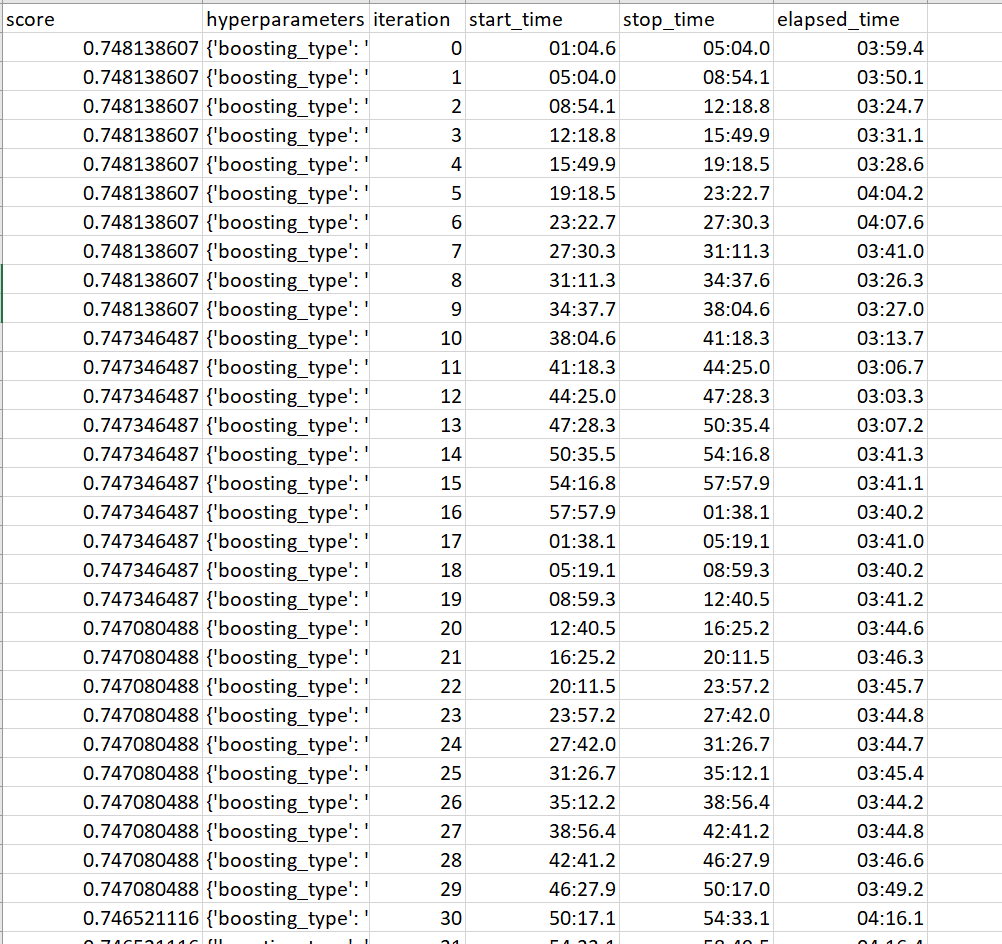

The GridSearch did pay off, however, as the official Kaggle score is now 0.72540!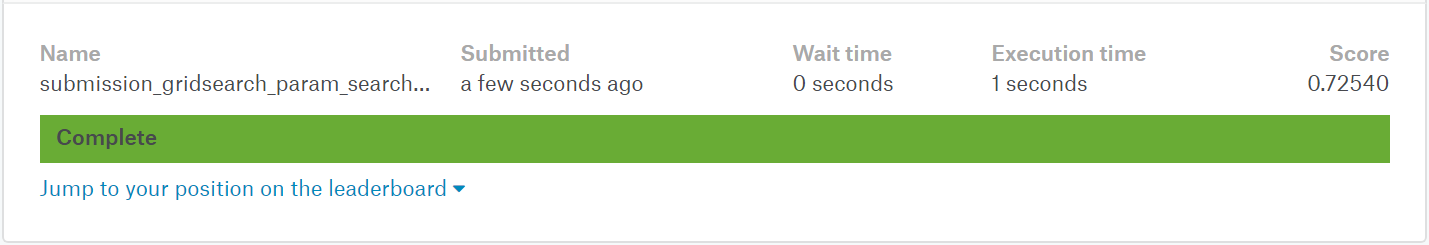

### One more stab at it...RandomSearch in a much smaller search / parameter space with additional data discovery

I thought I'd give this one more try. This time I am doing a random search in the much smaller parameter grid originally created for the grid search. Focused randomness, so to speak. To make things even a bit more clear, I'll do a deep dive on the hyperparameter space using data visualization and correlation analysis. 

In [244]:
param_data_csv = os.path.join(fileDir, 'random_search_results_40_iterations - flattened hyperparameters - no time stamps.csv')

#Read training data into pandas dataframe from CSV using built-in method
param_data = pd.read_csv(param_data_csv)

#Visualize data
print('Parameter data shape: ', param_data.shape)
param_data.head()

Parameter data shape:  (40, 13)


,score,Boosting type,Num Leaves,Learning Rate,Subsample for Bin,Min Child Samples,Reg Alpha,Reg Lambda,Colsample by Tree,Subsample,Is Unbalanced,N Estimators,iteration
0,0.746900,gbdt,62,0.015903,60000,175,0.673469,0.448980,0.600000,1.000000,False,73,35
1,0.746695,gbdt,22,0.006872,160000,445,0.816327,0.734694,0.600000,0.696970,False,247,11
2,0.746637,dart,95,0.005663,60000,335,0.510204,0.551020,0.822222,0.848485,True,1028,15
3,0.745646,dart,51,0.007965,20000,360,0.448980,0.795918,0.911111,0.535354,False,950,39
4,0.745500,gbdt,62,0.086339,200000,290,0.816327,0.102041,0.644444,0.944444,False,13,2


In [245]:
# One hot encode categoricals
param_data = pd.get_dummies(param_data)
print('Parameter data shape: ', param_data.shape)
param_data.head()

Parameter data shape:  (40, 15)


,score,Num Leaves,Learning Rate,Subsample for Bin,Min Child Samples,Reg Alpha,Reg Lambda,Colsample by Tree,Subsample,Is Unbalanced,N Estimators,iteration,Boosting type_dart,Boosting type_gbdt,Boosting type_goss
0,0.746900,62,0.015903,60000,175,0.673469,0.448980,0.600000,1.000000,False,73,35,0,1,0
1,0.746695,22,0.006872,160000,445,0.816327,0.734694,0.600000,0.696970,False,247,11,0,1,0
2,0.746637,95,0.005663,60000,335,0.510204,0.551020,0.822222,0.848485,True,1028,15,1,0,0
3,0.745646,51,0.007965,20000,360,0.448980,0.795918,0.911111,0.535354,False,950,39,1,0,0
4,0.745500,62,0.086339,200000,290,0.816327,0.102041,0.644444,0.944444,False,13,2,0,1,0


In [246]:
# Print correlations
correlations = param_data.corr()['score'].sort_values()
print(correlations.head(10))


Learning Rate        -0.803336
Colsample by Tree    -0.333452
Boosting type_goss   -0.307282
Subsample for Bin    -0.278376
Is Unbalanced        -0.274046
Num Leaves           -0.178586
Reg Lambda           -0.170884
Subsample            -0.170378
Reg Alpha            -0.012562
Boosting type_gbdt    0.117503
Name: score, dtype: float64


Learning rate and Subsample look like a promising candidates. Let's look at them and other hyperparameters)


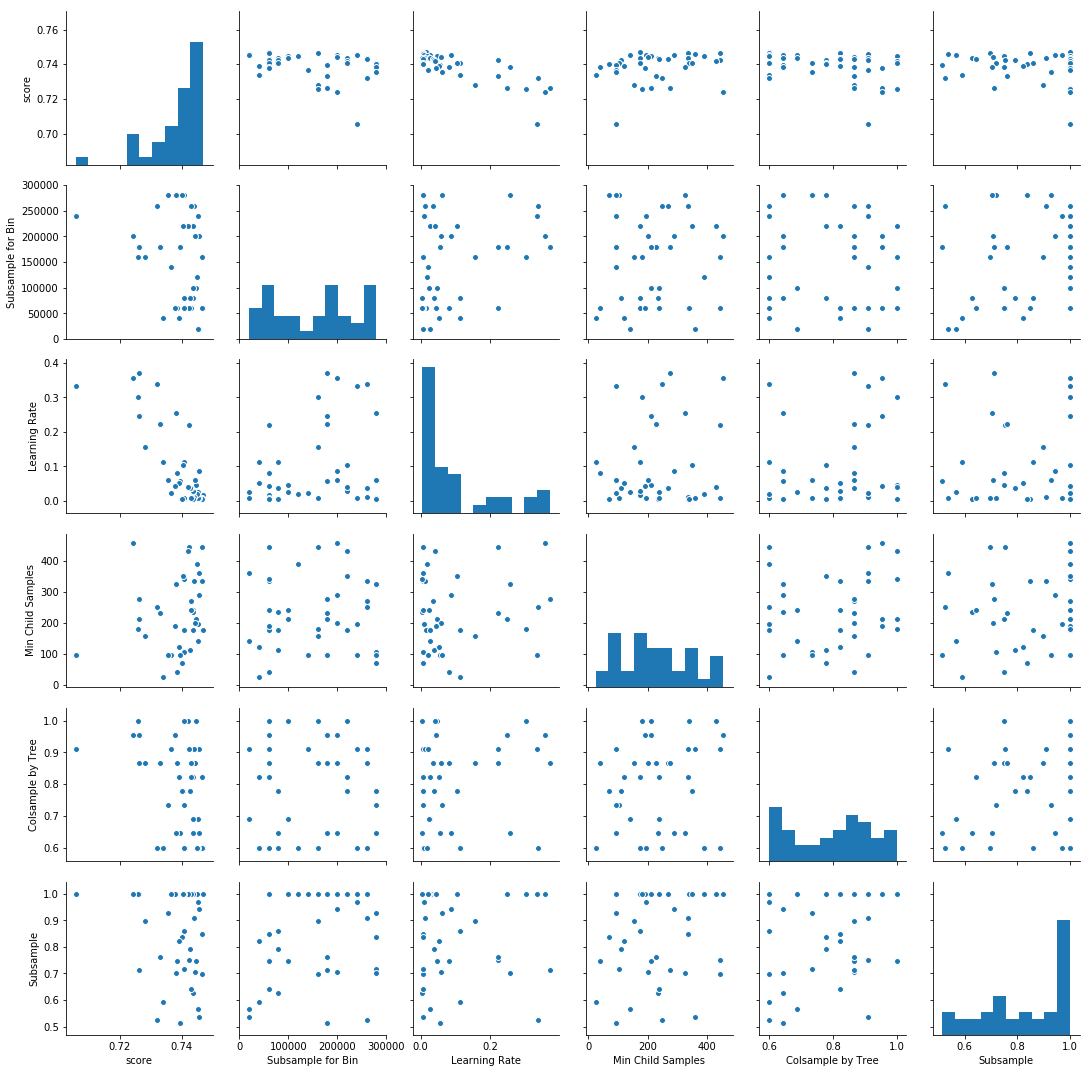

In [248]:
sample_data = param_data[['score', 'Subsample for Bin', 'Learning Rate','Min Child Samples', 'Colsample by Tree', 'Subsample']]
sns.pairplot(sample_data)

In [249]:
FocusedRandom_param_grid = {
    'boosting_type': ['gbdt', 'dart'],
    'num_leaves': list(range(50, 100,5)), #used smaller bucket since in none of the 100 iterations values were above 100
    'learning_rate': list(np.logspace(np.log10(0.003), np.log10(0.05), base = 10, num = 100)),
    'min_child_samples': list(range(400, 500, 5)), 
    'reg_alpha': list(np.linspace(0.1, 0.8,100)),
    'reg_lambda': list(np.linspace(0.1, 1,100)),
    'colsample_bytree': list(np.linspace(0.6, 0.9, 100)),
    'subsample': list(np.linspace(0.3, 0.9, 100)),
    'is_unbalance': [True, False]
}

In [250]:
# Create file and open connection
out_file = 'focused_random_search_results_domain_features_' + str(MAX_EVALS) +'_iterations.csv'
of_connection = open(out_file, 'w')
writer = csv.writer(of_connection)

# Write column names
headers = ['score', 'hyperparameters', 'iteration','start_time', 'stop_time', 'elapsed_time']
writer.writerow(headers)
of_connection.close()

In [251]:
#Expensive function call isolated into its own cell
focused_random_results = random_search(FocusedRandom_param_grid)

In [252]:
import pprint

print('The best validation score was {:.5f}'.format(focused_random_results.loc[0, 'score']))
print('\nThe best hyperparameters were:')

pprint.pprint(focused_random_results.loc[0, 'params'])

The best validation score was 0.74827

The best hyperparameters were:
{'boosting_type': 'dart',
 'colsample_bytree': 0.6575757575757576,
 'is_unbalance': True,
 'learning_rate': 0.009896493193757221,
 'metric': 'auc',
 'min_child_samples': 425,
 'n_estimators': 481,
 'num_leaves': 85,
 'reg_alpha': 0.5242424242424243,
 'reg_lambda': 0.709090909090909,
 'subsample': 0.5060606060606061,
 'verbose': 1}


In [255]:
# Get the best parameters
focused_random_search_params = focused_random_results.loc[0, 'params']

# Create, train, test model
model = lgb.LGBMClassifier(**focused_random_search_params, random_state = 42)
model.fit(train_features, train_labels)

preds = model.predict_proba(test_features)[:, 1]
print('The best model from focused random search scores {:.5f} ROC AUC on the test set.'.format(roc_auc_score(test_labels, preds)))

The best model from focused random search scores 0.74364 ROC AUC on the test set.


In [254]:
#Focused random parameter test
focused_random_param_search_test_ids = app_test_domain['SK_ID_CURR']
focused_random_param_search_test = app_test_domain.drop(columns = ['SK_ID_CURR'])

#Use existing model from above to create predictions for our test set
preds = model.predict_proba(focused_random_param_search_test)[:, 1]

# Generate submission file in approved format
submission = pd.DataFrame({'SK_ID_CURR': focused_random_param_search_test_ids, 'TARGET': preds})
submission.to_csv('submission_focused_random_param_search_plus_domain_and_poly_features_LGBM.csv', index = False)

Unfortunately, the higher Kfold ROC AUC score on the test set does not translate to a higher official Kaggle Score! We are starting to overfit, it appears! [focused_random_search_result_domain_poly_features.PNG](attachment:focused_random_search_result_domain_poly_features.PNG)